In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")


In [43]:
# Load your dataset
df = pd.read_csv("transactions.csv")
df.head()


,Transaction ID,Timestamp,Sender Name,Sender UPI ID,Receiver Name,Receiver UPI ID,Amount (INR),Status
0,4d3db980-46cd-4158-a812-dcb77055d0d2,2024-06-22 04:06:38,Tiya Mall,4161803452@okaxis,Mohanlal Golla,7776849307@okybl,3907.34,FAILED
1,099ee548-2fc1-4811-bf92-559c467ca792,2024-06-19 06:04:49,Mohanlal Bakshi,8908837379@okaxis,Mehul Sankaran,7683454560@okaxis,8404.55,SUCCESS
2,d4c05732-6b1b-4bab-90b9-efe09d252b99,2024-06-04 04:56:09,Kismat Bora,4633654150@okybl,Diya Goel,2598130823@okicici,941.88,SUCCESS
3,e8df92ee-8b04-4133-af5a-5f412180c8ab,2024-06-09 09:56:07,Ayesha Korpal,7018842771@okhdfcbank,Rhea Kothari,2246623650@okaxis,8926.00,SUCCESS
4,e7d675d3-04f1-419c-a841-7a04662560b7,2024-06-25 08:38:19,Jivin Batta,1977143985@okybl,Baiju Issac,5245672729@okybl,2800.55,SUCCESS


In [44]:
# Rename column for consistency
df.rename(columns={
    "Transaction ID": "transaction_id",
    "Timestamp": "timestamp",
    "Sender Name": "sender_name",
    "Sender UPI ID": "sender_upi",
    "Receiver Name": "receiver_name",
    "Receiver UPI ID": "receiver_upi",
    "Amount (INR)": "amount",
    "Status": "status"
}, inplace=True)

print(df.info())
print("\nClass Distribution:")
print(df["status"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   object 
 1   timestamp       1000 non-null   object 
 2   sender_name     1000 non-null   object 
 3   sender_upi      1000 non-null   object 
 4   receiver_name   1000 non-null   object 
 5   receiver_upi    1000 non-null   object 
 6   amount          1000 non-null   float64
 7   status          1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB
None

Class Distribution:
status
SUCCESS    502
FAILED     498
Name: count, dtype: int64


In [45]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 1. Extract transaction hour (0-23)
df['transaction_hour'] = df['timestamp'].dt.hour

# 2. Flag if transaction is on a weekend (Saturday=5, Sunday=6)
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

# 3. Number of previous transactions by the same sender (up to current row)
df['sender_txn_count'] = df.groupby('sender_upi').cumcount() + 1

# 4. Average transaction amount by the sender (helps detect abnormal spikes)
df['sender_avg_amount'] = df.groupby('sender_upi')['amount'].transform('mean')

# 5. High value flag — mark transactions above 95th percentile of all amounts
high_value_threshold = df['amount'].quantile(0.95)
df['is_high_value'] = df['amount'] > high_value_threshold

print(df)


                           transaction_id           timestamp  \
0    4d3db980-46cd-4158-a812-dcb77055d0d2 2024-06-22 04:06:38   
1    099ee548-2fc1-4811-bf92-559c467ca792 2024-06-19 06:04:49   
2    d4c05732-6b1b-4bab-90b9-efe09d252b99 2024-06-04 04:56:09   
3    e8df92ee-8b04-4133-af5a-5f412180c8ab 2024-06-09 09:56:07   
4    e7d675d3-04f1-419c-a841-7a04662560b7 2024-06-25 08:38:19   
..                                    ...                 ...   
995  843d87b5-902e-4336-9438-aa76d74e13e4 2024-07-03 23:15:06   
996  2dbbb577-4617-44b1-9a51-5fdf18ebb2ab 2024-06-15 15:42:57   
997  7c38e684-5968-432e-8acb-5bbe0f718fad 2024-06-18 17:27:37   
998  27624b55-fd6d-45ce-bbc5-0c2958d48865 2024-06-05 21:57:36   
999  b792bf64-2047-4435-aac1-27ee95b134d6 2024-06-21 15:52:40   

            sender_name             sender_upi   receiver_name  \
0             Tiya Mall      4161803452@okaxis  Mohanlal Golla   
1       Mohanlal Bakshi      8908837379@okaxis  Mehul Sankaran   
2           Kismat Bo

In [46]:
print(df['status'].value_counts())
print(df['status'].unique())
print(df.shape)
print(df.columns)
print(df.head())
# to check and examine the dataset properly can use matplot later

status
SUCCESS    502
FAILED     498
Name: count, dtype: int64
['FAILED' 'SUCCESS']
(1000, 13)
Index(['transaction_id', 'timestamp', 'sender_name', 'sender_upi',
       'receiver_name', 'receiver_upi', 'amount', 'status', 'transaction_hour',
       'is_weekend', 'sender_txn_count', 'sender_avg_amount', 'is_high_value'],
      dtype='object')
                         transaction_id           timestamp      sender_name  \
0  4d3db980-46cd-4158-a812-dcb77055d0d2 2024-06-22 04:06:38        Tiya Mall   
1  099ee548-2fc1-4811-bf92-559c467ca792 2024-06-19 06:04:49  Mohanlal Bakshi   
2  d4c05732-6b1b-4bab-90b9-efe09d252b99 2024-06-04 04:56:09      Kismat Bora   
3  e8df92ee-8b04-4133-af5a-5f412180c8ab 2024-06-09 09:56:07    Ayesha Korpal   
4  e7d675d3-04f1-419c-a841-7a04662560b7 2024-06-25 08:38:19      Jivin Batta   

              sender_upi   receiver_name        receiver_upi   amount  \
0      4161803452@okaxis  Mohanlal Golla    7776849307@okybl  3907.34   
1      8908837379@okaxis  Meh

In [47]:
df['status'] = df['status'].astype(str).str.upper().map({
    'SUCCESS': 0,
    'FAILED': 1
})
print(df['status'])

X = df.drop(columns=['status', 'timestamp', 'transaction_id', 'sender_name', 'receiver_name', 'sender_upi', 'receiver_upi'])
y = df['status']



0      1
1      0
2      0
3      0
4      0
      ..
995    0
996    1
997    1
998    1
999    0
Name: status, Length: 1000, dtype: int64


In [68]:
# tratified K-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


X_top3 = df[['amount', 'sender_avg_amount', 'transaction_hour']]
y = df['status']


# Step 1: Final test split (for evaluation only)
X_train_full, X_final_test, y_train_full, y_final_test = train_test_split(
    X_top3, y, test_size=0.3, stratify=y, random_state=42
)

# Step 2: SMOTE on training data only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_full, y_train_full)

# Step 3: Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Decision Tree and Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dtree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# Step 5: Fit on resampled data
grid_search.fit(X_resampled, y_resampled)

# Step 6: Evaluate on final test set
best_dtree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_dtree.predict(X_final_test)

print("\nClassification Report:")
print(classification_report(y_final_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_final_test, y_pred))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       151
           1       0.49      0.59      0.54       149

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.49       300
weighted avg       0.50      0.50      0.49       300

Confusion Matrix:
[[61 90]
 [61 88]]


In [66]:
# i used train spilt method and smote gridseachcv as well also top3 features

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Split
top_features = ['amount', 'sender_avg_amount', 'transaction_hour']
X = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_dtree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predictions & evaluation
y_pred = best_dtree.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       151
           1       0.55      0.62      0.58       149

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.56      0.56      0.55       300

Confusion Matrix:
[[74 77]
 [56 93]]


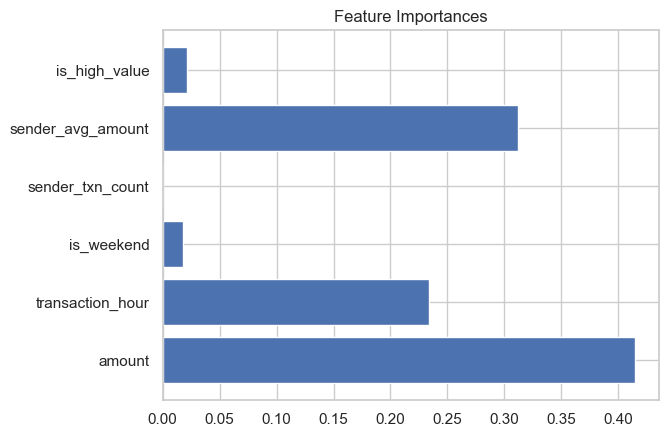

In [65]:
import matplotlib.pyplot as plt
importances = best_dtree.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Feature Importances")
plt.show()


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [55]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = grid_search.best_estimator_

# Evaluate best model on test data
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.26      0.33       100
           1       0.47      0.66      0.55       100

    accuracy                           0.46       200
   macro avg       0.45      0.46      0.44       200
weighted avg       0.45      0.46      0.44       200


Confusion Matrix:
[[26 74]
 [34 66]]


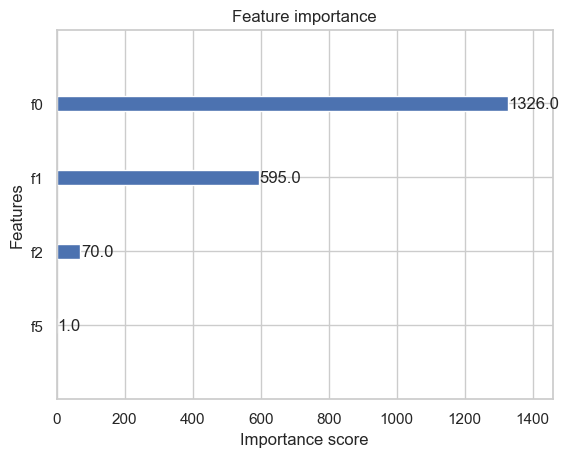

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.49      0.52       100
           1       0.54      0.59      0.56       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200


Confusion Matrix:
 [[49 51]
 [41 59]]


In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, y_train_resampled)

y_pred = xgb.predict(X_test_scaled)

import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb, max_num_features=10)
plt.show()

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [59]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train_resampled, y_train_resampled)


y_pred = dt_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       100
           1       0.57      0.55      0.56       100

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200

Confusion Matrix:
[[59 41]
 [45 55]]


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['FAILED' 'SUCCESS']

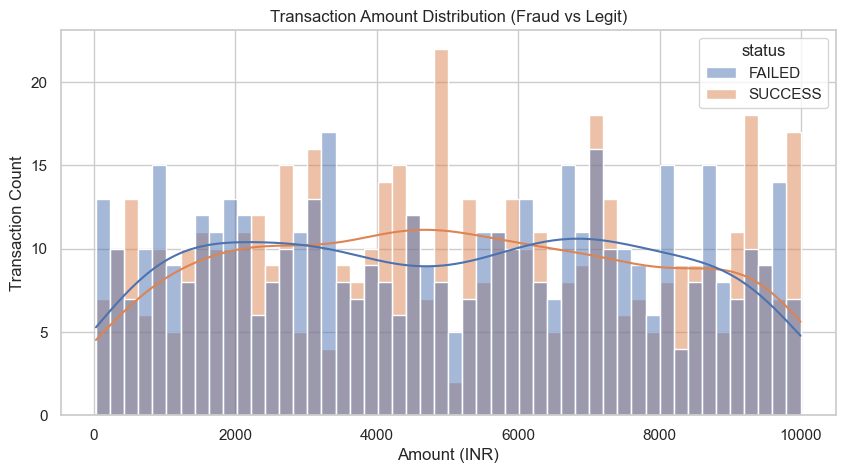

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='amount', hue='status', bins=50, kde=True)
plt.title("Transaction Amount Distribution (Fraud vs Legit)")
plt.xlabel("Amount (INR)")
plt.ylabel("Transaction Count")
plt.show()


In [11]:
print(df_processed['status'].unique())


[1 0]


In [10]:
from sklearn.preprocessing import LabelEncoder

df_processed = df.copy()

# Encode sender/receiver UPI IDs
le = LabelEncoder()
df_processed['sender_upi'] = le.fit_transform(df_processed['sender_upi'])
df_processed['receiver_upi'] = le.fit_transform(df_processed['receiver_upi'])

# Map 'status' column
df_processed['status'] = df_processed['status'].str.upper().map({
    'SUCCESS': 0,
    'FAILED': 1
}).astype(int)


df_processed.drop(['transaction_id', 'timestamp', 'sender_name', 'receiver_name'], axis=1, inplace=True)

df_processed.head()


,sender_upi,receiver_upi,amount,status
0,445,787,3907.34,1
1,899,769,8404.55,0
2,490,252,941.88,0
3,709,208,8926.00,0
4,221,527,2800.55,0


In [13]:

X = df_processed.drop("status", axis=1)
y = df_processed["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


model = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [14]:
# print(X_train.dtypes)
print(y_test)
print(y_pred)

459    1
50     1
515    1
478    1
127    0
      ..
69     0
721    0
954    0
277    0
441    0
Name: status, Length: 300, dtype: int64
[1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0
 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1
 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1
 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0
 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1
 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 1]


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       151
           1       0.51      0.52      0.52       149

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300

Confusion Matrix:


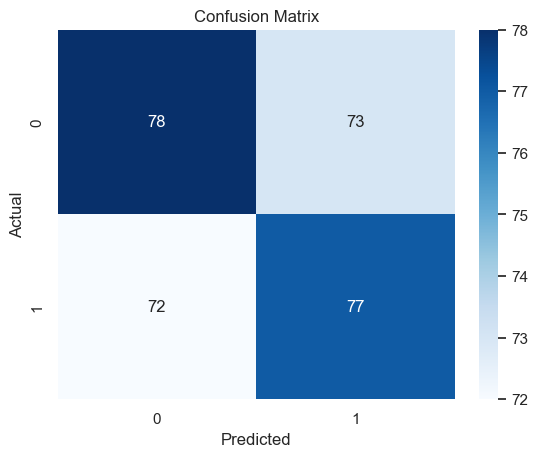

In [15]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


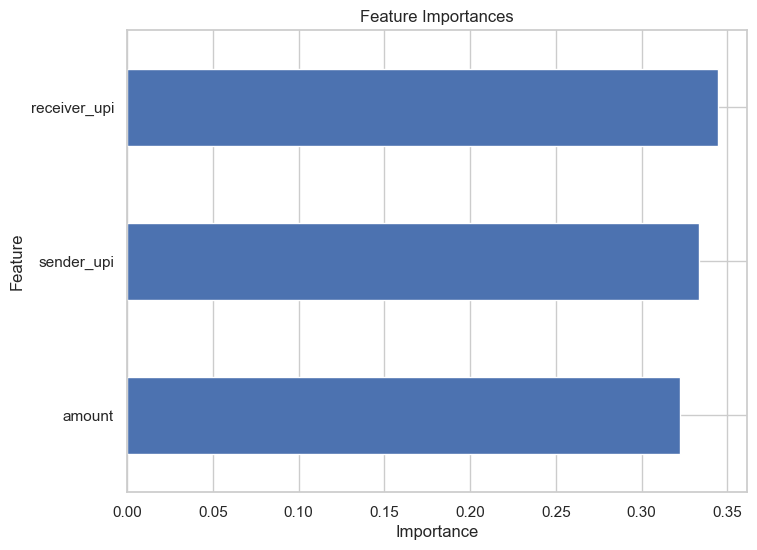

In [16]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [1]:
import sys
print(sys.executable)
# MAKE SURE CORRECT PYHTO ENVIRONMENT IS USED LIKE THE MODULE IS IN SAME ENVIRONMENT AS THE USED IN THIS KERNEL



/opt/anaconda3/bin/python


In [22]:
from xgboost import XGBClassifier

counter = Counter(y_train)
ratio = counter[0] / counter[1] 

xgb = XGBClassifier(scale_pos_weight=ratio)  # ratio = (non-fraud / fraud)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.46      0.44      0.45       151
           1       0.46      0.49      0.48       149

    accuracy                           0.46       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.46      0.46      0.46       300

